# RaBitQ Walkthrough

This notebook walks through Randomized Binary Quantization (RaBitQ) step by step.

**RaBitQ (Gao & Long, SIGMOD 2024):** Apply a random orthogonal transform, binarize to a D-bit code, and store 2 scalar corrections per vector. Provides an unbiased distance estimator with O(1/sqrt(D)) error bound.

**Key properties:**
- Compression: D×4 bytes → D/8 + 8 bytes
- Unbiased distance estimator
- Error bound: O(1/sqrt(D))
- No hyperparameters (just a random seed)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
rng = np.random.default_rng(42)

## 1. The Key Idea: Random Projection + Binarization

RaBitQ works by:
1. Centering vectors (subtract dataset mean)
2. Normalizing to unit length
3. Applying a random orthogonal transform P^T
4. Binarizing: keep only the sign of each dimension
5. Storing scalar corrections to make the estimator unbiased

In [2]:
D = 128
n_train = 5000
n_db = 2000
n_queries = 50

X_train = rng.standard_normal((n_train, D)).astype(np.float32)
X_db = X_train[:n_db]
X_queries = rng.standard_normal((n_queries, D)).astype(np.float32)

print(f'Data: D={D}, n_train={n_train}, n_db={n_db}, n_queries={n_queries}')

Data: D=128, n_train=5000, n_db=2000, n_queries=50


## 2. Step by Step: The RaBitQ Encoding Pipeline

In [3]:
from src.utils.math import random_orthogonal_matrix

# Step 1: Compute centroid
centroid = np.mean(X_train, axis=0)
print(f'Centroid norm: {np.linalg.norm(centroid):.4f}')

# Step 2: Center a vector
x = X_db[0]
x_centered = x - centroid

# Step 3: Normalize
x_norm = np.linalg.norm(x_centered)
x_bar = x_centered / x_norm
print(f'||x - centroid|| = {x_norm:.4f}')
print(f'||x_bar|| = {np.linalg.norm(x_bar):.6f} (should be 1.0)')

# Step 4: Random orthogonal projection
P = random_orthogonal_matrix(D, seed=42)
x_proj = x_bar @ P  # P^T @ x_bar
print(f'||x_proj|| = {np.linalg.norm(x_proj):.6f} (preserved by orthogonal transform)')

Centroid norm: 0.1506
||x - centroid|| = 9.0387
||x_bar|| = 1.000000 (should be 1.0)
||x_proj|| = 1.000000 (preserved by orthogonal transform)


Fraction of 1-bits: 0.555 (should be ~0.5)
Storage: 128 bits = 16 bytes


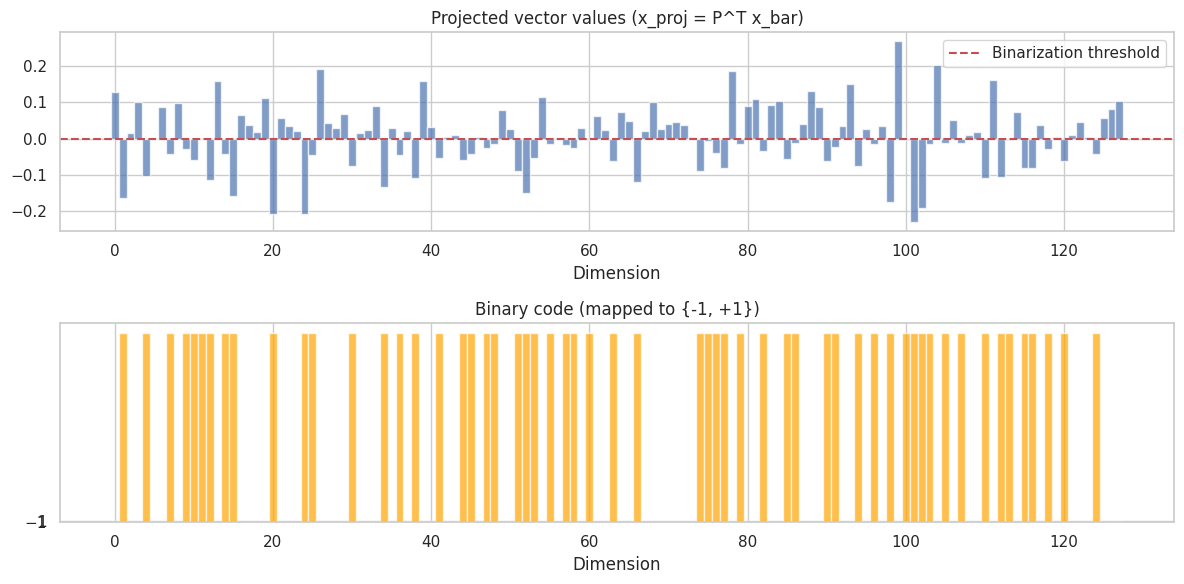

In [4]:
# Step 5: Binarize
bits = (x_proj > 0).astype(np.uint8)
print(f'Fraction of 1-bits: {np.mean(bits):.3f} (should be ~0.5)')
print(f'Storage: {D} bits = {D // 8} bytes')

# Visualize: projected values and binarization threshold
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.bar(range(D), x_proj, width=1.0, alpha=0.7)
ax1.axhline(y=0, color='r', linestyle='--', label='Binarization threshold')
ax1.set_title('Projected vector values (x_proj = P^T x_bar)')
ax1.set_xlabel('Dimension')
ax1.legend()

ax2.bar(range(D), 2*bits - 1, width=1.0, alpha=0.7, color='orange')
ax2.set_title('Binary code (mapped to {-1, +1})')
ax2.set_xlabel('Dimension')
ax2.set_yticks([-1, 1])
plt.tight_layout()

## 3. The Correction Scalar

The binary vector `o_bar = (2b - 1) / sqrt(D)` approximates the unit vector `x_bar_proj`.
The correction `<o_bar, x_bar_proj>` captures how well the binary code approximates the original.

Correction scalar <o_bar, x_proj> = 0.7601
This tells us how well the binary code represents the vector
Perfect match would give 1/sqrt(D) * D * (1/sqrt(D)) = 1.0


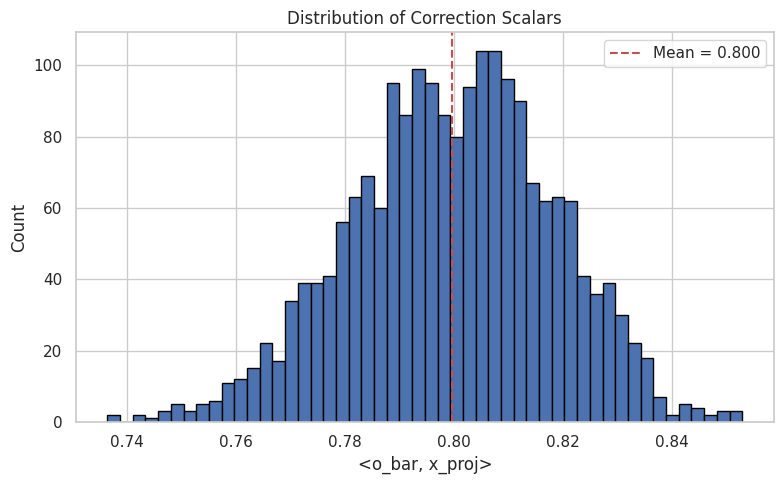

In [5]:
o_bar = (2.0 * bits - 1.0) / np.sqrt(D)
correction = np.dot(o_bar, x_proj)
print(f'Correction scalar <o_bar, x_proj> = {correction:.4f}')
print(f'This tells us how well the binary code represents the vector')
print(f'Perfect match would give 1/sqrt(D) * D * (1/sqrt(D)) = 1.0')

# Distribution of corrections across database
centered_all = X_db - centroid
norms_all = np.linalg.norm(centered_all, axis=1, keepdims=True)
x_bar_all = centered_all / np.maximum(norms_all, 1e-10)
x_proj_all = x_bar_all @ P
bits_all = (x_proj_all > 0).astype(np.float32)
o_bar_all = (2.0 * bits_all - 1.0) / np.sqrt(D)
corrections = np.sum(o_bar_all * x_proj_all, axis=1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(corrections, bins=50, edgecolor='black')
ax.axvline(x=np.mean(corrections), color='r', linestyle='--',
           label=f'Mean = {np.mean(corrections):.3f}')
ax.set_xlabel('<o_bar, x_proj>')
ax.set_ylabel('Count')
ax.set_title('Distribution of Correction Scalars')
ax.legend()
plt.tight_layout()

## 4. Distance Estimation

RaBitQ estimates `<x', q'>` (inner product of centered vectors) as:

$$\langle x', q' \rangle \approx \|x'\| \cdot \frac{\langle \bar{o}, q_{proj} \rangle}{\langle \bar{o}, \bar{x}_{proj} \rangle}$$

Then: $\|x - q\|^2 = \|x'\|^2 + \|q'\|^2 - 2\langle x', q' \rangle$

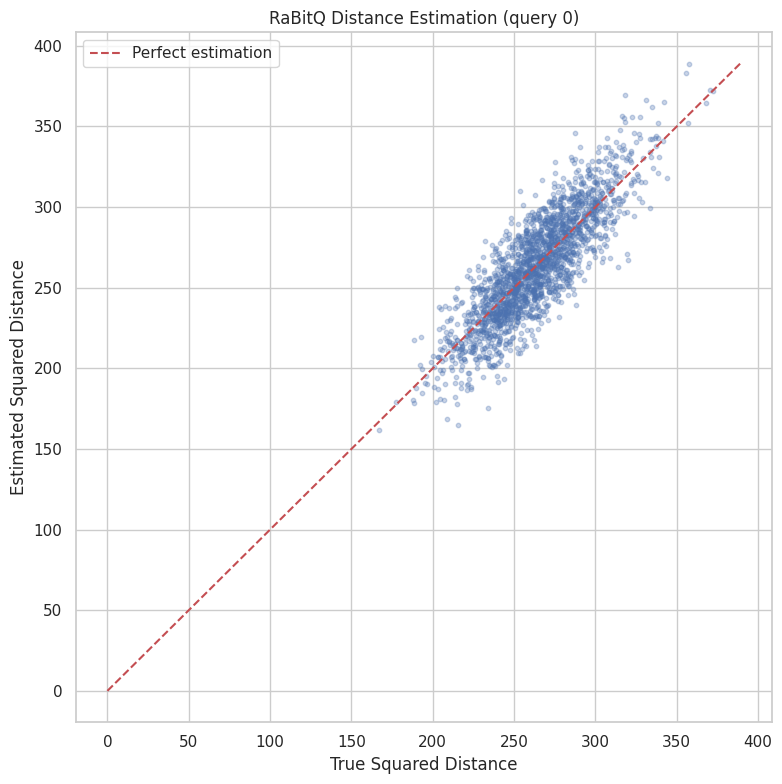

In [6]:
from src.quantizers.rabitq import RaBitQ
from src.search.exhaustive import exhaustive_search

rq = RaBitQ(seed=42)
rq.fit(X_train)
rq.build_database(X_db)

# Compare estimated vs true distances
est_dists = rq.estimate_distances(X_queries[:10])
true_dists = np.sum((X_queries[:10, np.newaxis] - X_db[np.newaxis]) ** 2, axis=2)

# Scatter plot for one query
qi = 0
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(true_dists[qi], est_dists[qi], alpha=0.3, s=10)
lim = max(true_dists[qi].max(), est_dists[qi].max())
ax.plot([0, lim], [0, lim], 'r--', label='Perfect estimation')
ax.set_xlabel('True Squared Distance')
ax.set_ylabel('Estimated Squared Distance')
ax.set_title('RaBitQ Distance Estimation (query 0)')
ax.legend()
plt.tight_layout()

## 5. Unbiasedness

A key theoretical property of RaBitQ: the distance estimator is unbiased.

Mean relative error: -0.0001 (should be ~0)
Std relative error:  0.0662


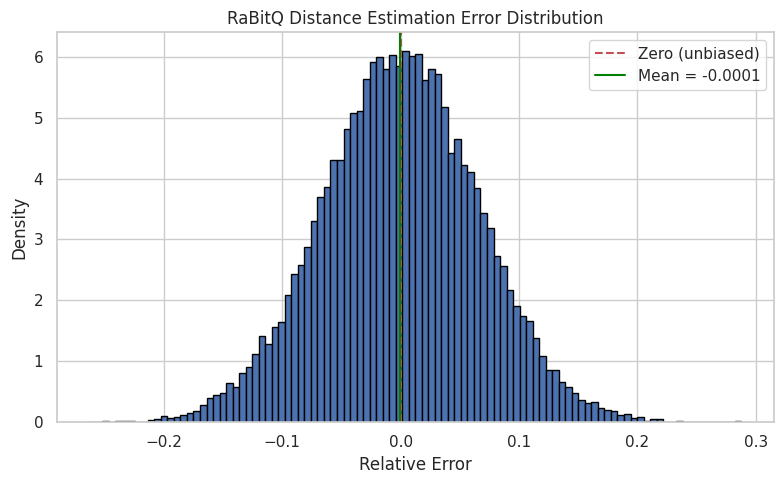

In [7]:
# Relative errors
mask = true_dists > 1.0
rel_errors = (est_dists[mask] - true_dists[mask]) / true_dists[mask]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(rel_errors, bins=100, edgecolor='black', density=True)
ax.axvline(x=0, color='r', linestyle='--', label='Zero (unbiased)')
ax.axvline(x=np.mean(rel_errors), color='green', linestyle='-',
           label=f'Mean = {np.mean(rel_errors):.4f}')
ax.set_xlabel('Relative Error')
ax.set_ylabel('Density')
ax.set_title('RaBitQ Distance Estimation Error Distribution')
ax.legend()
plt.tight_layout()

print(f'Mean relative error: {np.mean(rel_errors):.4f} (should be ~0)')
print(f'Std relative error:  {np.std(rel_errors):.4f}')

## 6. Error Scaling with Dimension

RaBitQ's error scales as O(1/sqrt(D)), so higher dimensions give better estimates.

D=  64: std(relative error) = 0.0958
D= 128: std(relative error) = 0.0670
D= 256: std(relative error) = 0.0471
D= 512: std(relative error) = 0.0332


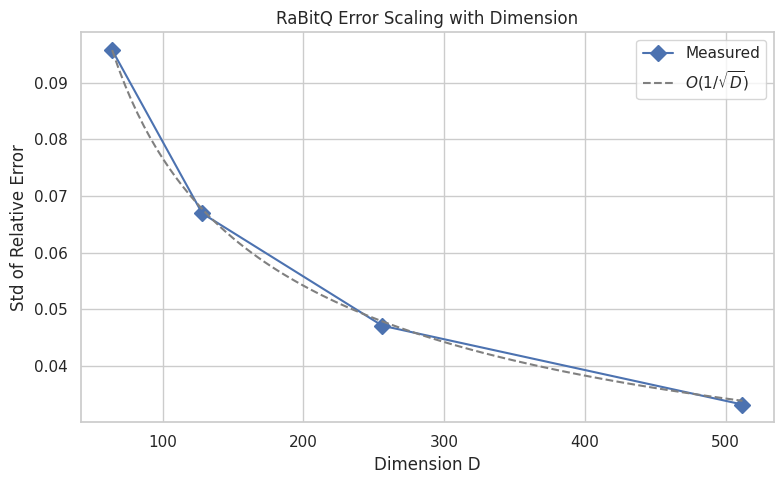

In [8]:
dims = [64, 128, 256, 512]
error_stds = []

for d in dims:
    X_d = rng.standard_normal((2000, d)).astype(np.float32)
    Q_d = rng.standard_normal((20, d)).astype(np.float32)
    
    rq_d = RaBitQ(seed=42)
    rq_d.fit(X_d)
    rq_d.build_database(X_d)
    
    est = rq_d.estimate_distances(Q_d)
    true = np.sum((Q_d[:, np.newaxis] - X_d[np.newaxis]) ** 2, axis=2)
    
    m = true > 1.0
    rel = (est[m] - true[m]) / true[m]
    error_stds.append(np.std(rel))
    print(f'D={d:4d}: std(relative error) = {error_stds[-1]:.4f}')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(dims, error_stds, 'D-', markersize=8, label='Measured')
# Theoretical reference
scale = error_stds[0] * np.sqrt(dims[0])
d_range = np.linspace(dims[0], dims[-1], 100)
ax.plot(d_range, scale / np.sqrt(d_range), '--', color='gray', label=r'$O(1/\sqrt{D})$')
ax.set_xlabel('Dimension D')
ax.set_ylabel('Std of Relative Error')
ax.set_title('RaBitQ Error Scaling with Dimension')
ax.legend()
plt.tight_layout()

## 7. Search Quality

In [9]:
from src.evaluation.metrics import recall_at_k

k = 10
rq = RaBitQ(seed=42)
rq.fit(X_train)
rq.build_database(X_db)

rq_idx, rq_dist = rq.search(X_queries, k=k)
true_idx, _ = exhaustive_search(X_queries, X_db, k=k)

recall = recall_at_k(rq_idx, true_idx, k=k)
print(f'RaBitQ recall@{k} = {recall:.3f}')
print(f'Memory: {rq.memory_usage() / 1024:.1f} KB')
print(f'Compression ratio: {X_db.nbytes / rq.memory_usage():.1f}x (excluding P matrix)')

RaBitQ recall@10 = 0.370
Memory: 110.9 KB
Compression ratio: 9.0x (excluding P matrix)
